# Example: Inferring Lag Times from Experimental Data
---

In this notebook, I will develop an empirical method for i) identifying distinct 
growth phases in a diauxic shift curve and ii) quantification of the lag time.

In [94]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.signal
import diaux.viz 
import diaux.quant
cor, pal = diaux.viz.matplotlib_style()

First, we will load and display an example growth curve. This curve is of 
NCM3722 (`GC001`) *E. coli* grown in a Chi.Bio bioreactor on a minimal medium 
with scant (0.5 mM) glucose and abundant (30 mM) acetate. Following our physiological
understanding of *E. coli*, growth will first occur exclusively utilizing the 
glucose, upon the exhaustion of glucose, the cells adapt and eventually begin 
growing on acetate.

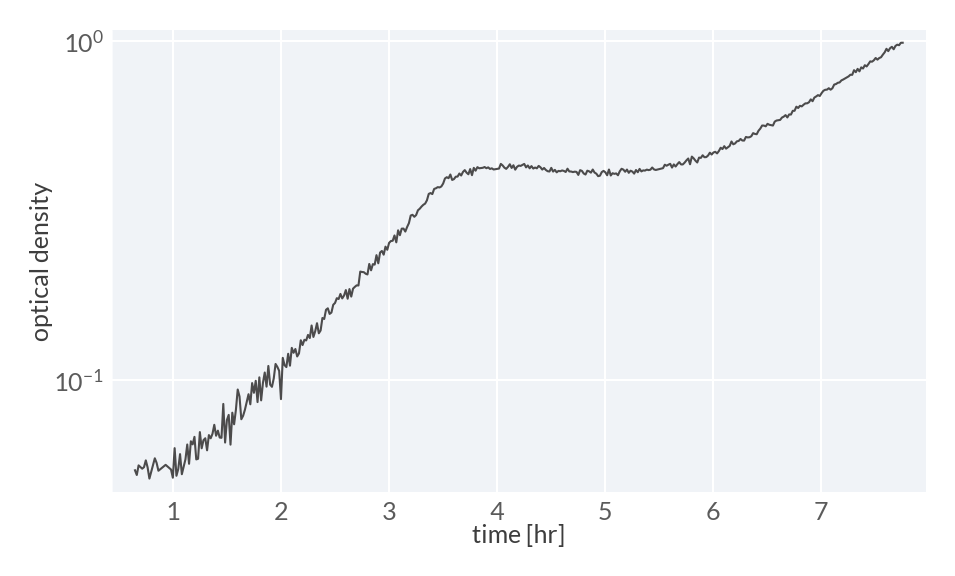

In [95]:
# Load and plot the example data
data = pd.read_csv('../../data/examples/example_growth_curve.csv')
plt.figure(figsize=(3.5, 2))
plt.plot(data['time_hr'], data['od650nm'], '-')
plt.xlabel('time [hr]', fontsize=6)
plt.ylabel('optical density', fontsize=6)
plt.yscale('log')

We note that there are frequent measurements (occurring every 60 seconds) with some 
amount of noise. The magnitude of that noise is most visible in the first growth 
phase where the fluctuations are small. 


We want to classify this growth curve into three distinct phases -- the 
preshift exponential growth, the lag phase, and the postshift exponential growth.
By definition, we will say that "exponential growth" is defined as the region where 
the scaling between the logarithm of the optical density is approximately linear 
with time, and the lag phase will be defined as the intervening period. We will 
use the Pearson correlation coefficient between the log OD and time dimension 
over a sliding window of the data, starting with time $t=0$. This correlation 
coefficient is computed as 
$$
\rho = \frac{\text{cov}\left(\log OD_{650nm},t\right)}{\sigma(\log OD_{650nm})\sigma(t)},
\tag{1}
$$

where $\sigma$ is the standard deviation and $\text{cov}$ is the covariance. Regions 
where $\rho$ is approximately 1 will indicate approximate linear regions. Below, 
we show the correlation coefficient over an array of window sizes. 

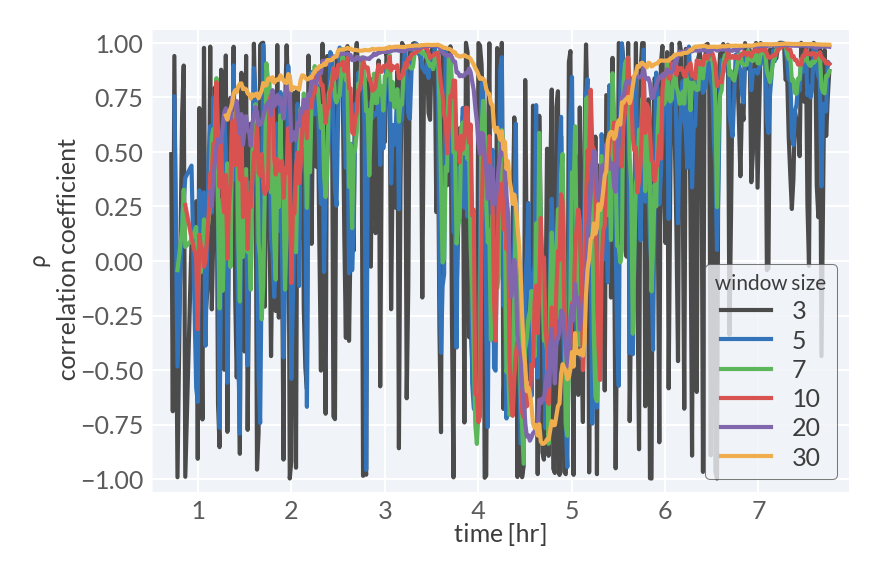

In [96]:
# Define sliding window sizes
window_sizes = [3, 5, 7, 10, 20, 30]
# Set up a figure
plt.figure(figsize=(3, 2))
# Iterate through each window
data['log_od650nm'] = np.log(data['od650nm'])
for i, w in enumerate(window_sizes):
    # Apply a rolling window 
    out = data[['time_hr', 'log_od650nm']].rolling(w).corr().reset_index()
    out = out[out['level_1']=='time_hr']['log_od650nm']
    corr = out[w:]

    # Plot the correlation coefficient as a function of time
    plt.plot(data['time_hr'].values[w:], corr, '-', lw=1, label=w)

plt.xlabel('time [hr]', fontsize=6)
plt.ylabel(r'$\rho$' + '\n correlation coefficient', fontsize=6)
leg = plt.legend(title='window size', fontsize=6)
leg.get_title().set_fontsize(5)

This is a very noisy result, requiring a window size of 20 or 30 minutes, to get a 
clear result. This can be improved by applying a Savitsky-Golay filter over 
the log transformed optical density.

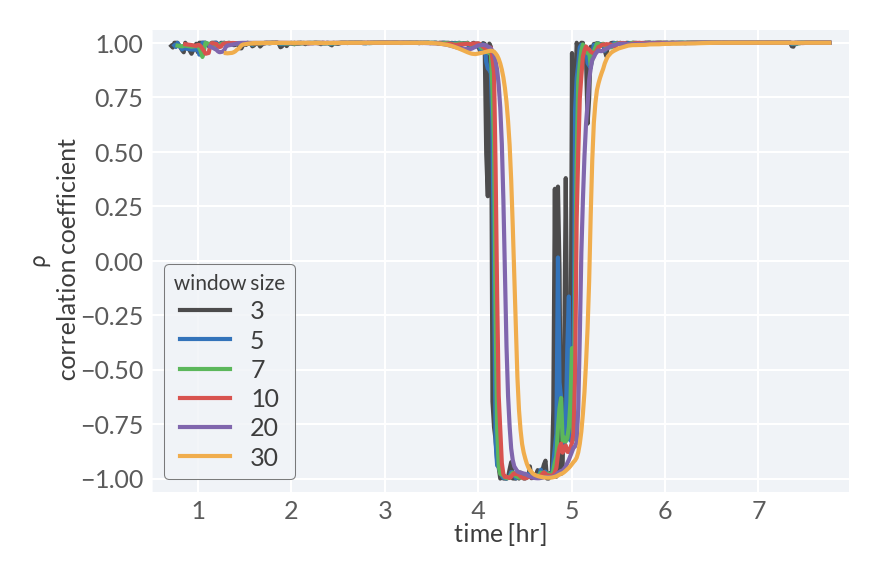

In [97]:
# Set up a figure
plt.figure(figsize=(3, 2))
# Iterate through each window

for i, w in enumerate(window_sizes):
    # Set a median filter with a sliding window of 5
    data['log_od650nm'] = scipy.signal.savgol_filter(np.log(data['od650nm'].values), window_length=50,
                                                     polyorder=3)

    # Apply a rolling window 
    out = data[['time_hr', 'log_od650nm']].rolling(w).corr().reset_index()
    out = out[out['level_1']=='time_hr']['log_od650nm']
    corr = out[w:]

    # Plot the correlation coefficient as a function of time
    plt.plot(data['time_hr'].values[w:], corr, '-', lw=1, label=w)

plt.xlabel('time [hr]', fontsize=6)
plt.ylabel(r'$\rho$' + '\n correlation coefficient', fontsize=6)
leg = plt.legend(title='window size', fontsize=6)
leg.get_title().set_fontsize(5)

This greatly improves the situation, but there are still jumps and spikes in the 
correlation coefficient even with a 10 min sliding window. We will err on the 
side of caution and use a 30 min sliding window for identifying where the transition
hits. To do so, we will apply some threshold, say $\rho \geq 0.98$ to denote
the linear regions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


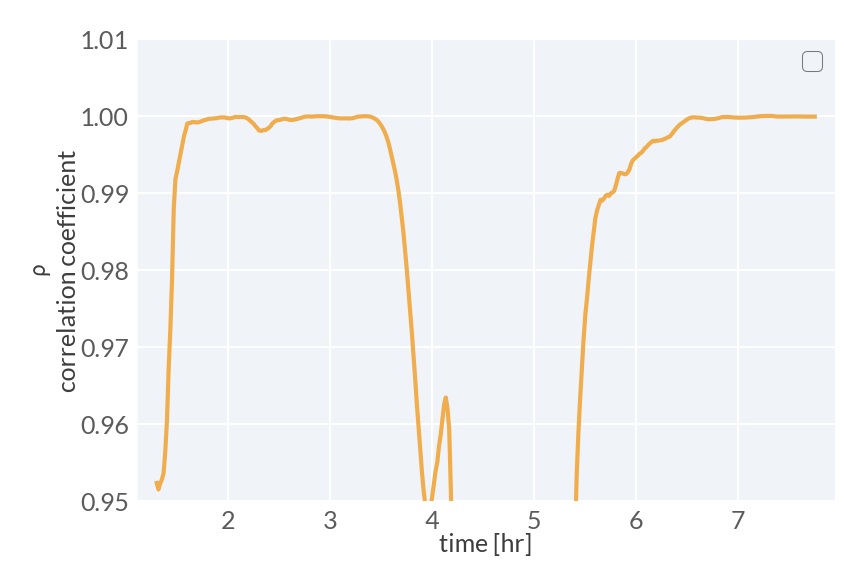

In [98]:
# Plot the threshold to identify the region
THRESH = 0.99
plt.figure(figsize=(3, 2))
plt.plot(data['time_hr'].values[w:], corr, '-', color=cor['primary_gold'],
         lw=1)
plt.ylim([0.95, 1.01])
# plt.hlines(THRESH, 0, 8, color=cor['primary_red'],
        #    label='correlation threshold',
        #    lw=1)
plt.xlabel('time [hr]', fontsize=6)
plt.ylabel(r'$\rho$' + '\ncorrelation coefficient', fontsize=6)
plt.legend()

We can map onto the dataframe where the linear regions are with simple boolean 
mapping.


In [106]:
# Find the locations of the shifts. 
WINDOW = w
LAG_THRESH = 0.5
locs = corr <= LAG_THRESH
data['stalled'] =  True
data.loc[w:, 'stalled'] = locs.values

In [107]:
len(data)

418

We can now trim the data such that we start at the beginning of the first exponential 
phase and end at the final point of the second exponential. 


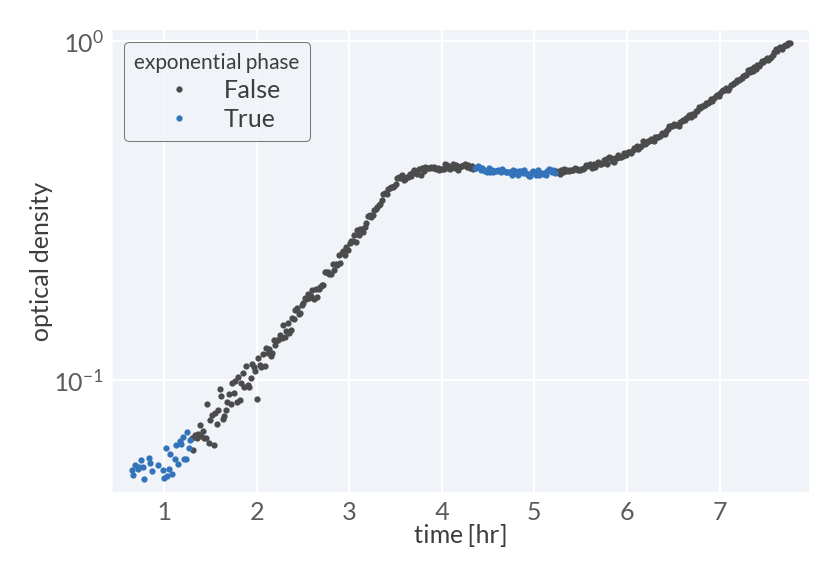

In [108]:
# Find the indices where transitions happen in the correlation space
transitions = np.where(np.diff(np.sign(locs.astype(int))) != 0)[0]
# if locs.values[0] == True:
#     t_start = data['time_hr'].min()
# else:
#     t_start = data['time_hr'].values[WINDOW:][transitions[0]]
# if locs.values[-1] == True:
#     t_end = data['time_hr'].max()
# else:  
#     t_end = data['time_hr'].values[WINDOW:][transitions[-1]]
# data_trimmed = data[(data['time_hr'] > t_start) & 
#                     (data['time_hr'] < t_end)].copy()
# # plot the different phases
fig = plt.figure(figsize=(3,2))
for g, d in data.groupby('stalled'):
    plt.plot(d['time_hr'], d['od650nm'], '.', label=g, lw=1, ms=3,
             markeredgewidth=0)
plt.xlabel('time [hr]', fontsize=6)
plt.ylabel('optical density', fontsize=6)
plt.yscale('log')
leg = plt.legend(title='exponential phase', fontsize=6)
leg.get_title().set_fontsize(5)

We now wish to more carefully annotate the different phases into preshift exponential,
postshift exponential, and lag phase.

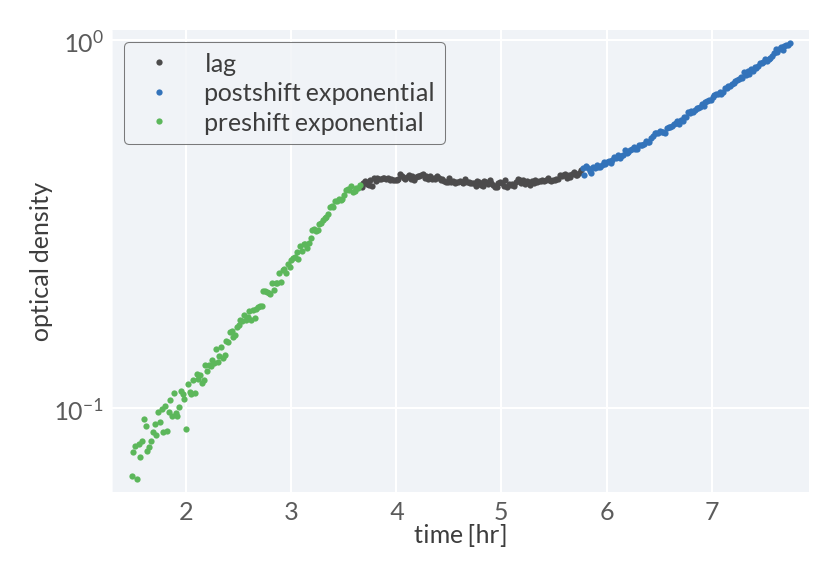

In [53]:

# Label the phases
t_lag_begin = data['time_hr'].values[WINDOW:][transitions[1]]
t_lag_end = data['time_hr'].values[WINDOW:][transitions[2]]
data_trimmed['phase'] = 'lag'
data_trimmed.loc[data_trimmed['time_hr'] < t_lag_begin, 'phase'] = 'preshift exponential'
data_trimmed.loc[data_trimmed['time_hr'] > t_lag_end, 'phase'] = 'postshift exponential'

# Plot the result 
fig, ax = plt.subplots(1,1, figsize=(3, 2))
for g, d in data_trimmed.groupby('phase'):
    ax.plot(d['time_hr'], d['od650nm'], '.', ms=3, markeredgewidth=0, label=g)
ax.set_xlabel('time [hr]', fontsize=6)
ax.set_ylabel('optical density', fontsize=6)
ax.legend(fontsize=6)
ax.set_yscale('log')


Below is a function which does this procedure, avoiding calling pandas functions 
which can be slow. 

In [13]:
fig = plt.figure(figsize=(3, 2))
for g, d in corr.groupby('annotation'):
    plt.plot(d['time_hr'], d['log_optical_density_filtered'], '.',
             ms=4, markeredgewidth=0)
# plt.yscale('log')


KeyError: 'annotation'

<Figure size 900x600 with 0 Axes>

In [14]:
labeled

NameError: name 'labeled' is not defined

In [75]:
import numpy as np 
import pandas as pd 
from scipy.ndimage import median_filter as scipy_median_filter
from scipy.stats import pearsonr as scipy_pearsonr

def annotate_diauxic_phases(time, 
                            optical_density,
                            pearson_thresh=0.98,
                            pearson_window=30,
                            minimum_window=5,
                            median_filter=True,
                            median_filter_window=20):
    """
    Classifies portions of a diauxic shift growth curve using a Pearson-correlation
    rolling filter. 

    Parameters
    ----------
    time : numpy.ndarray 
        The time dimension of the growth curve. 
    optical_density : numpy.ndarray
        The  measured optical density of the the growth curve as a function of time.
    pearson_thresh : float (0, 1]
        The threshold above which the log optical density is considered to be 
        linear and, thus, in the exponential growth phase. 
    pearson_window: integer
        The size of the window over which to compute the correlation coefficient. 
        Default is 30 points
    median_filter : bool
        If True, the growth curve will be median filtered before the correlation 
        coefficient is applied. Default is True 
    median_filter_window : odd integer
        The size of the kernel for the median filtering. Only applied if
        `median_filter` is True. Default is 11. 
    
    Returns
    -------
    annotation : pandas DataFrame
        A pandas DataFrame with trimmed data. Regions are labeled as `preshift-exponential`,
        `lag`, and `postshift-exponential`. 
    """
    # Log transform the the optical density and median filt if desired. 
    log_od = np.log(optical_density)
    if median_filter:
        log_od = scipy.signal.savgol_filter(np.log(optical_density),polyorder=1,
                window_length=50)
        # log_od = scipy_median_filter(log_od, size=median_filter_window,
                                            #  mode='nearest')
        log_label = '_filtered'
    else:
        log_label = ''

    # Compute the pearson correlation coefficients and apply the threshold     
    corr = np.empty(len(log_od) - pearson_window)
    for i in range(len(log_od)-pearson_window):
        corr[i] = scipy_pearsonr(time[i:i+pearson_window], log_od[i:i+pearson_window])[0]
    corr_thresh = corr >= pearson_thresh
    
    # Clip the time and log OD given the window size to avoid indexing slips.
    _time = time[:-pearson_window]
    _log_od = log_od[:-pearson_window]
    _optical_density = optical_density[:-pearson_window]

    # Identify the indices of the transition and apply logic to make sure 
    # the entry/exit logic is in phase. 
    _transitions = np.where(np.diff(np.sign(corr_thresh.astype(int))) != 0)[0]

    # Filter the transitions, keeping only those longer than the provided minimum
    # window. 
    last_valid_transition = _transitions[0]
    transitions = [last_valid_transition]

    for i, v in enumerate(np.diff(_transitions)):
        if v >= minimum_window:
            last_valid_transition = _transitions[i+1]
            transitions.append(last_valid_transition)
    print(transitions, _transitions)
    # Fail loudly when there are no distinct phases
    if len(transitions) == 0:
        raise ValueError("No distinct phases identified!")

    # Fail loudly if there are an unexpect number of transitions. Valid 
    # number of transitions are:
    #       2 -> Indicates starts and end in steady-state, with the transitions
    #            marking the beginning and end of the lag phase.
    #       3 -> Indicates either starting OR ending in a steady-state, with 
    #            two transitions marking the beginning and end of the lag phase,
    #           with another noting the start or end of the exponenetial phases. 
    #       4 -> Indicates that the data does not start OR end in an exponential
    #            phase.
    if (len(transitions) < 2) | (len(transitions) > 4):
        raise RuntimeError("Too many or too few transitions detected.")

    if corr_thresh[0] == False: 
        _time = _time[transitions[0]:] 
        _optical_density = _optical_density[transitions[0]:]
        _log_od = _log_od[transitions[0]:]
        corr = corr[transitions[0]:]

        # Modify the transitions in place to ignore the first non-exponential
        # measurements
        transitions -= transitions[0]
        transitions = transitions[1:]
    if corr_thresh[-1] == False:
        _time = _time[:transitions[-1]]
        _optical_density = _optical_density[:transitions[-1]] 
        corr = corr[:transitions[1]]      

    # Create the phase labels
    _phases = np.ones_like(_time)
    _phases[0:transitions[0]] = 0 
    _phases[transitions[1]:] = 2
    mapper = {0:'preshift-exponential',
              1:'lag',
              2:'postshift-exponential'}
    phases = [mapper[p] for p in _phases]
    
    # Pack into a pandas DataFrame and assemble. 
    annotation = pd.DataFrame(np.array([_time, 
                                        _optical_density, 
                                        _log_od,
                                        corr]).T, 
                               columns=['time_hr', 
                                        'optical_density',
                                        'log_optical_density' + log_label,
                                        'correlation_coeff'])
    annotation['annotation'] = phases
                                        
    return annotation



In [76]:
data = pd.read_csv('../experiments/2024-04-17_NCM3722_glucose-acetate_shift/processed/2024-04-17_complete_growth_curves.csv')
# data.head()
# labeled = annotate_diauxic_phases(data['time_hr'].values, data['od650nm'].values)


In [82]:
rep = data[(data['tech_rep']==2) & 
            (data['od650nm'] >= 0.1) &
            (data['od650nm'] <= 1.25)]

trn = annotate_diauxic_phases(rep['time_hr'].values, rep['od650nm'].values,
pearson_thresh=0.98)




[91, 196] [ 91 196]


[83, 201] [ 83 201]


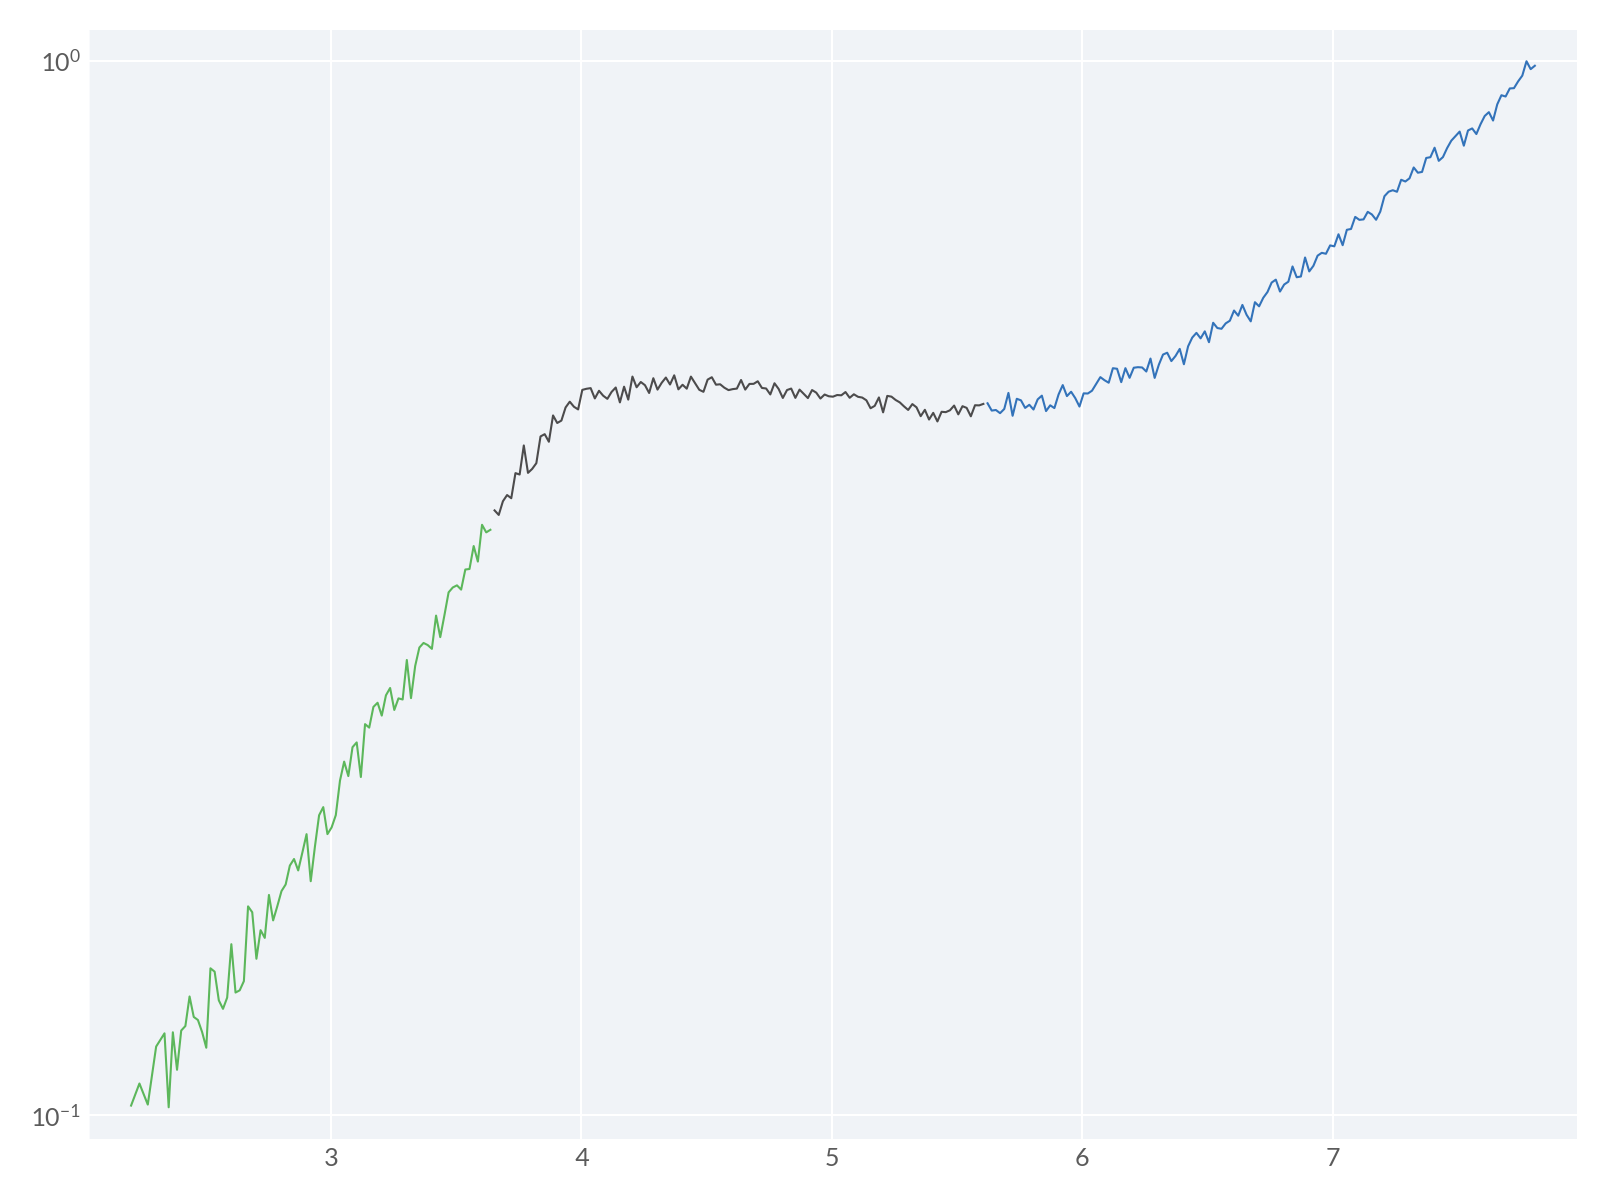

In [86]:
labeled = annotate_diauxic_phases(rep['time_hr'].values, rep['od650nm'].values,
                                  pearson_thresh=0.99)
for g, d in labeled.groupby('annotation'):
    plt.plot(d['time_hr'], d['optical_density'])
plt.yscale('log')

In [19]:
fit = scipy.signal.savgol_filter(np.log(labeled['optical_density']),polyorder=1,
window_length=31)

plt.plot(labeled['time_hr'].values[:-2], np.diff(np.diff(fit)))

NameError: name 'labeled' is not defined

In [20]:
fit = scipy.signal.savgol_filter(np.log(labeled['optical_density']),polyorder=1,
window_length=11)

plt.plot(labeled['time_hr'], np.log(labeled['optical_density']), 'k-', lw=1)
plt.plot(labeled['time_hr'], fit, 'r-', lw=1)

NameError: name 'labeled' is not defined

(0.9, 1.1)

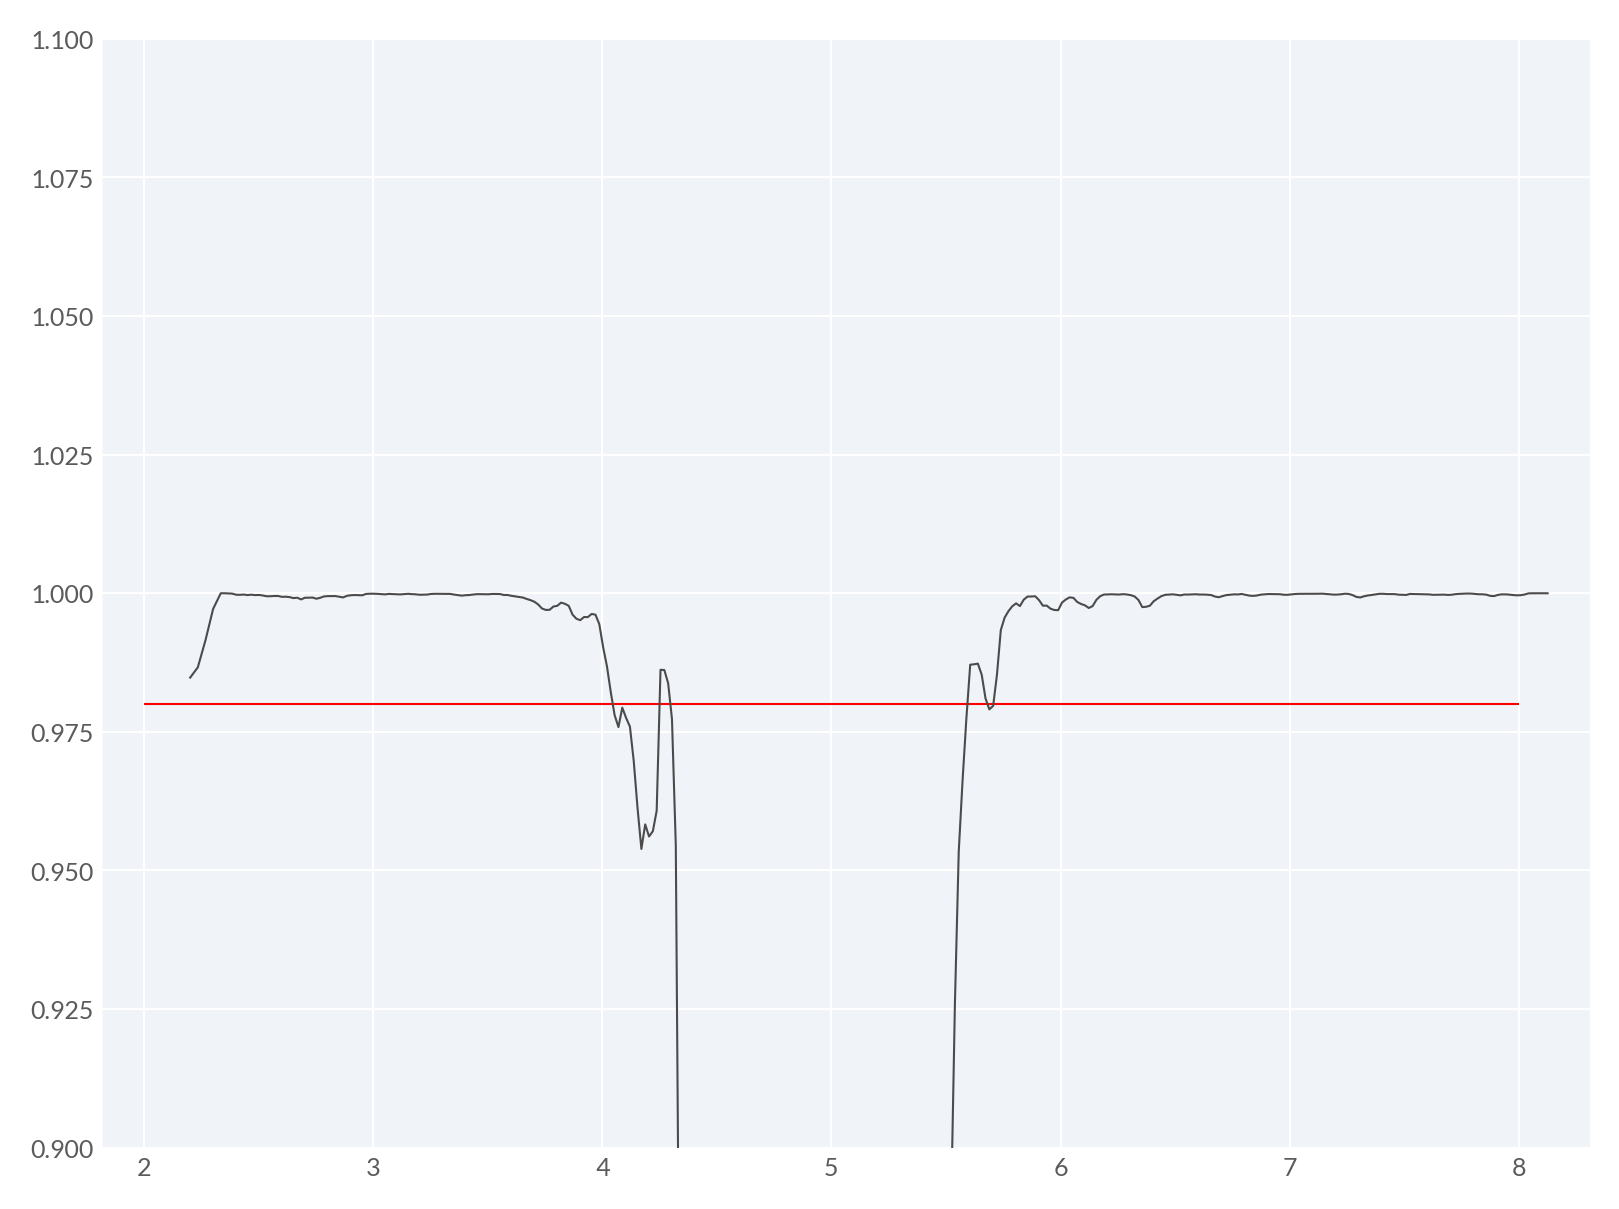

In [365]:
plt.hlines(0.98, 2, 8, color='r')
plt.plot(labeled['time_hr'], labeled['correlation_coeff'])
plt.ylim([0.9, 1.1])

In [366]:
labeled

,time_hr,optical_density,log_optical_density_filtered,correlation_coeff,annotation
0,2.202247,0.102015,-2.249533,0.984789,preshift-exponential
1,2.235614,0.107059,-2.236683,0.986640,preshift-exponential
2,2.268983,0.102240,-2.223834,0.991521,preshift-exponential
3,2.302369,0.116058,-2.210985,0.997181,preshift-exponential
4,2.335728,0.119458,-2.198136,1.000000,preshift-exponential
...,...,...,...,...,...
347,8.058094,1.129895,0.104218,1.000000,postshift-exponential
348,8.074772,1.108703,0.112610,1.000000,postshift-exponential
349,8.091458,1.143740,0.121002,1.000000,postshift-exponential
350,8.108144,1.132881,0.129394,1.000000,postshift-exponential
